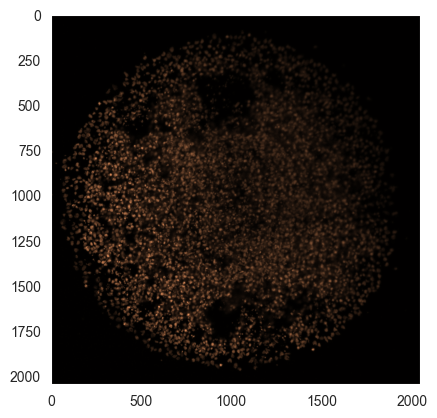

In [52]:
from micropattern_analysis import *
import imageio.v3 as iio
import matplotlib.pyplot as plt
import numpy as np

files = [file for file in gather_files("C:/Users/flori/OneDrive - Universität Wien/Adameyko Lab/FS1_MP_ISTA_MIFF1/") if
         "ISL" not in file]
img = iio.imread(files[-1])
plt.imshow(img[0][0], cmap="gray")
plt.imshow(img[0][1], cmap="copper")
plt.grid(False)
plt.show()

In [22]:
edu, dapi = np.argmax(np.sum(np.sum(img, axis=2), axis=2), axis=0)

In [67]:
from skimage.filters import threshold_li, threshold_isodata, threshold_sauvola, threshold_niblack
from skimage.morphology import white_tophat, black_tophat

edu_image = img[edu][0]
dapi_image = img[dapi][1]

edu_image = edu_image > threshold_li(edu_image)
dapi_image = dapi_image > threshold_li(dapi_image)

edu_count = np.count_nonzero(edu_image)
dapi_count = np.count_nonzero(dapi_image)
total_count = np.count_nonzero(edu_image * dapi_image)

#plt.imshow(dapi_image, cmap="gray_r")
#plt.show()
print(dapi_count, edu_count)

1486807 1014645


In [76]:
from skimage.filters import threshold_li
import os

path = "C:/Users/flori/OneDrive - Universität Wien/Adameyko Lab/FS1_MP_ISTA_MIFF1/"
time = []
ratio = []
for file in gather_files(path):
    if "ISL" not in file:
        img = iio.imread(file)

        edu, dapi = np.argmax(np.sum(np.sum(img, axis=2), axis=2), axis=0)
        edu_image = img[edu][0]
        dapi_image = img[dapi][1]

        edu_image = edu_image > threshold_li(edu_image)
        dapi_image = dapi_image > threshold_li(dapi_image)

        edu_count = np.count_nonzero(edu_image)
        dapi_count = np.count_nonzero(dapi_image)
        total_count = np.count_nonzero(edu_image * dapi_image)

        time.append(f"{os.path.basename(os.path.dirname(file))}")
        ratio.append(total_count / dapi_count)
dic = {
    "time": time,
    "ratio": ratio
}

In [ ]:
# TODO: compare positive edu pixels to normal image
# TODO: number of dapi positive pixels vs. time
# TODO: compare unedited edu images vs. time
# TODO: edu distance from center
# TODO: compare this with distances of other zones

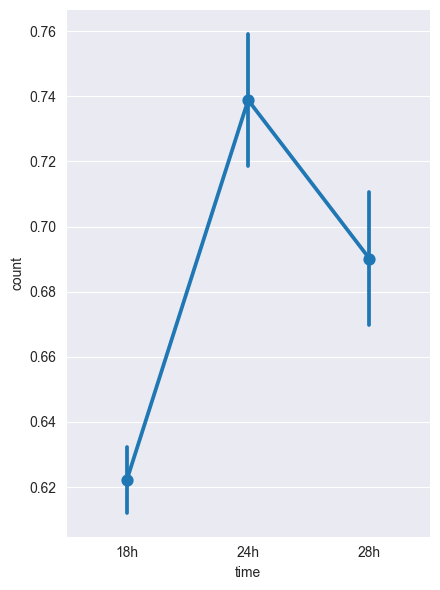

In [77]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(dic)
sns.catplot(df, x="time", y="count", errorbar="se",
            kind="point", height=6, aspect=.75)

### Preprocessing

In [1]:
from micropattern_analysis import *
from support_functions import *

from statannotations.Annotator import Annotator
from toolz import pipe

In [2]:
dir = r"C:\Users\flori\OneDrive - Universität Wien\Adameyko Lab\FS1_MP_ISTA_MIFF1"
os.chdir(dir)
dirs = os.listdir(".")
print(dirs)

['18h', '24h', '28h', 'Control']


In [3]:
dirs = dirs[0:3]
print(dirs)

['18h', '24h', '28h']


In [101]:
file_names, images = zip(*get_files_and_images(dirs).items())

In [102]:
images = list(map(
    lambda x:
    pipe(
        x,
        lambda f: maximise_img_channels(f),
    ),
    images[2:])
)

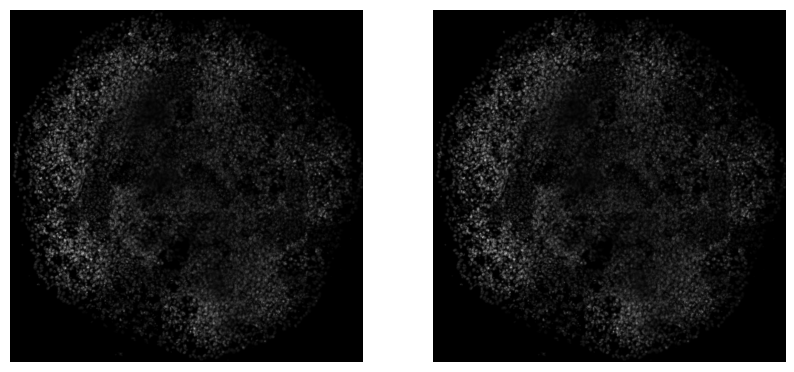

In [103]:
from skimage.exposure import match_histograms

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 20))

ax1.imshow(match_histograms(images[0], images[0])[1], cmap="grey")
ax1.axis('off')
ax2.imshow(images[0][1], cmap="grey")
ax2.axis('off')
plt.show()

In [135]:
import skimage.exposure as exp
import skimage.filters as filters

v_new = list(
    map(
        lambda x: pipe(
            x,
            lambda f: exp.equalize_hist(f),
            lambda f: exp.equalize_adapthist(f),
            #lambda f: exp.match_histograms(f, images[0])
        ),
        images
    )
)

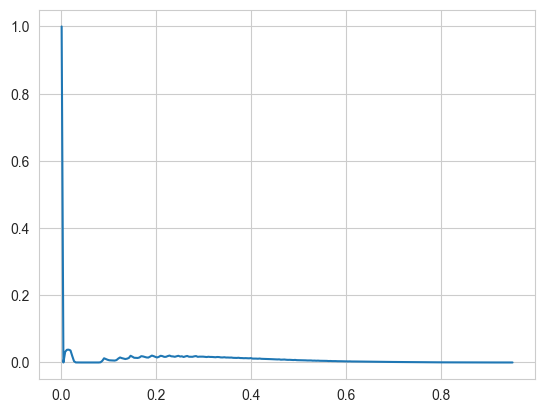

In [136]:
img_hist, bins = exp.histogram(v_new[0][1])
plt.plot(bins, img_hist / img_hist.max())

In [106]:
time_labels = [f.split("\\")[0] for f in file_names[2:]]

In [140]:
channel_num = 1

thresholds = list(
    map(
        lambda x: filters.threshold_multiotsu(x[channel_num], classes=4)[1],
        v_new
    )
)

dict = {
    "thresholds": thresholds,
    "images": time_labels
}
df = pd.DataFrame(dict)

(<Axes: xlabel='images', ylabel='thresholds'>,
  <statannotations.Annotation.Annotation at 0x27148752310>])

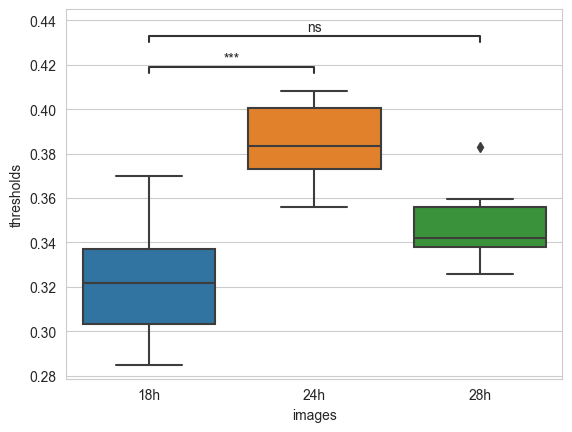

In [141]:
fig, ax = plt.subplots()

sns.boxplot(data=df, y="thresholds", x="images", ax=ax)
annotator = Annotator(ax=ax, pairs=[('18h', '24h'), ("18h", "28h")], data=df, y="thresholds", x="images", verbose=0)
annotator.configure(test="t-test_ind")
annotator.apply_and_annotate()

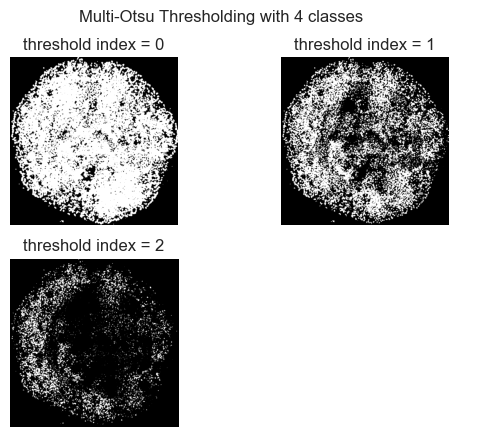

In [139]:
plot_multi_otsu_thresholds(v_new[0], 1, 4)

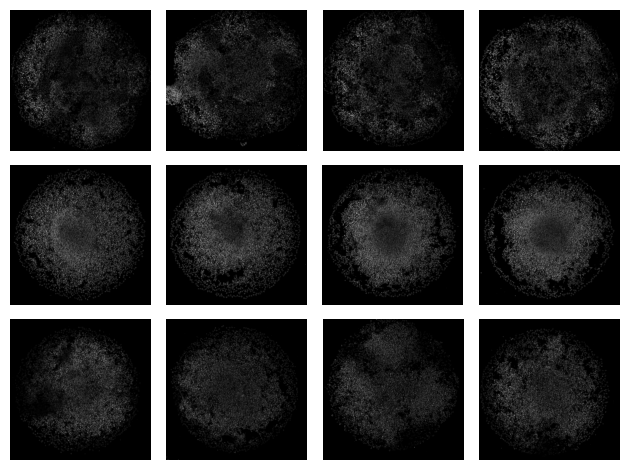

In [153]:
fig, axes = plt.subplots(nrows=3, ncols=4)
channel_num = 0
imgs = images
img18 = np.delete(imgs[:4], channel_num, 1)
img24 = np.delete(imgs[10:14], channel_num, 1)
img28 = np.delete(imgs[-5:-1], channel_num, 1)
imgs = np.array([img18, img24, img28])

for i, img in enumerate(imgs):
    for ax, channel in zip(axes[i], img):
        ax.imshow(channel[0], cmap="grey")
        ax.axis('off')
axes[0][0].set_ylabel("18h")
axes[1][0].set_ylabel("24h")
axes[2][0].set_ylabel("28h")
plt.tight_layout()
plt.show()

In [75]:
dapi_num = 1

v_new = list(map(
    lambda x:
    pipe(
        x,
        lambda f: apply_multiotsu_to_image(f, dapi_num),
        lambda f: apply_multiotsu_to_channel(f, 0)
    ),
    v_new)
)

print(f'Original shape:\t{images[2].shape}')
print(f'New shape:\t{v_new[0].shape}')

Original shape:	(2, 2048, 2048)
New shape:	(2, 2048, 2048)


In [151]:
iio.immeta(os.path.join(dir, file_names[2]))

{'byteorder': '<',
 'is_andor': False,
 'is_svs': False,
 'is_stk': False,
 'is_eer': False,
 'is_epics': False,
 'is_bif': False,
 'is_frame': False,
 'is_uniform': False,
 'is_fei': False,
 'is_tiffep': False,
 'is_tvips': False,
 'is_mrc': False,
 'is_ome': False,
 'is_ndpi': False,
 'is_astrotiff': False,
 'is_sis': False,
 'is_streak': False,
 'is_qpi': False,
 'is_vista': False,
 'is_agilent': False,
 'is_micromanager': False,
 'is_scanimage': False,
 'is_imagej': False,
 'is_shaped': False,
 'is_multipage': False,
 'is_nih': False,
 'is_gdal': False,
 'is_scn': False,
 'is_sem': False,
 'is_subifd': False,
 'is_virtual': False,
 'is_lsm': True,
 'MagicNumber': 67127628,
 'StructureSize': 464,
 'DimensionX': 2048,
 'DimensionY': 2048,
 'DimensionZ': 3,
 'DimensionChannels': 2,
 'DimensionTime': 1,
 'DataType': 0,
 'ThumbnailX': 128,
 'ThumbnailY': 128,
 'VoxelSizeX': 4.1513291048191956e-07,
 'VoxelSizeY': 4.1513291048191956e-07,
 'VoxelSizeZ': 4.9999999999999996e-06,
 'OriginX': 

### Image Processing

In [79]:
def time_point(file):
    file_params = os.path.basename(file).split("_")
    return file_params[3]

In [80]:
df = []
channel_names = ["EdU", "DAPI"]

for file, img in zip(file_names[2:], v_new):
    df_mini = generate_data_frame(
        expand_coordinate_matrix(img[dapi_num]),
        img,
        channel_names,
        Distances=get_distances(img[dapi_num])
    )
    df_mini = scale_distances(df_mini, file=file)
    df_mini = group_distances(df_mini, channel_names)
    df_mini = smooth_distances(df_mini, channel_names, sigma=3)
    df_mini["Time"] = np.repeat(time_point(file), df_mini.shape[0])
    df.append(df_mini)

df = pd.concat(df)

### Analysis

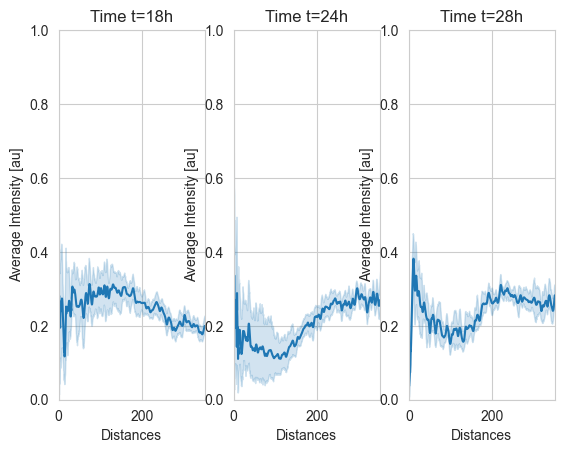

In [82]:
fig, axes = plt.subplots(1, 3)

time_points = ["18h", "24h", "28h"]

for ax, t in zip(axes.flat, time_points):
    df_sub = df[df["Time"] == t]
    df_sub.reset_index(inplace=True)
    sns.lineplot(data=df_sub, x="Distances", y="EdU", ax=ax)
    ax.set_ylabel("Average Intensity [au]")
    ax.set_title(f"Time t={t}")
    ax.set_xlim((0, 350))
    ax.set_ylim((0, 1))

In [76]:
dict = {
    "Time": [f.split("\\")[0] for f in file_names[2:]],
    "Area Ratio":
        list(map(
            lambda x:
            regionprops((x[0] > 0).astype(int))[0].area / 
            regionprops((x[1] > 0).astype(int))[0].area
            ,
            v_new
        )
        )
}

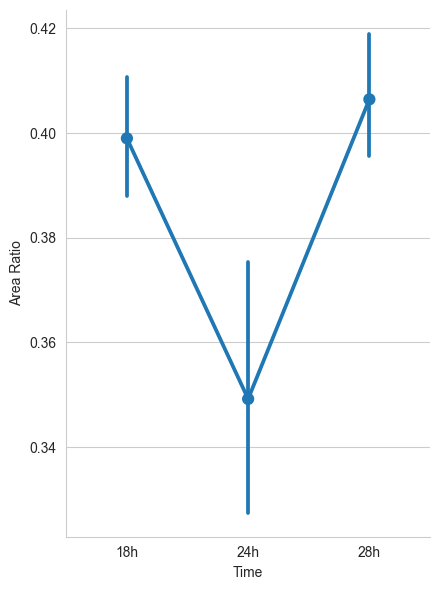

In [77]:
sns.catplot(data=pd.DataFrame(dict), x="Time", y="Area Ratio", errorbar="se",
            kind="point", height=6, aspect=.75)

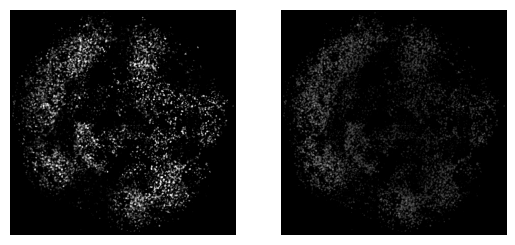

In [35]:
fig, axes = plt.subplots(1, 2)

plot_all_channels(axes, v_new[0])

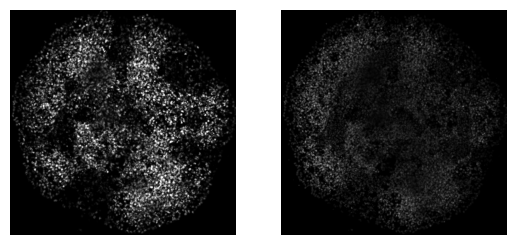

In [37]:
fig, axes = plt.subplots(1, 2)

plot_all_channels(axes, maximise_and_normalize(images[2]))